In [31]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf

from PIL import Image
import cv2

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


import xgboost
import warnings
warnings.filterwarnings("ignore")


In [32]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
classes = ['NORMAL', 'PNEUMONIA']

all_images = []
all_labels = []
for split in ['train', 'test', 'val']:
    for cls in classes:
        class_dir = os.path.join(base_dir, split, cls)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_images.append(os.path.join(class_dir, img_file))
                    all_labels.append(cls)


In [33]:
from sklearn.model_selection import train_test_split

# Step 1: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, 
    test_size=0.4,        # 40% reserved for val+test
    random_state=42, 
    stratify=all_labels
)

# Step 2: 5% val, 35% test from the 40% temp
# 5% out of 40% is 0.125 (so test_size=0.875 means 35% test, 0.125 means 5% val)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.875,      # 87.5% of 40% = 35% of total for test, 12.5% of 40% = 5% of total for val
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)}")
print(f"Val: {len(X_val)}")
print(f"Test: {len(X_test)}")

Train: 3513
Val: 292
Test: 2051


In [34]:
import cv2
import numpy as np

IMG_SIZE = (224, 224)
def load_images(image_paths, labels):
    valid_images = []
    valid_labels = []
    for path, label in zip(image_paths, labels):
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            valid_images.append(img)
            valid_labels.append(label)
    return np.array(valid_images), np.array(valid_labels)

train_images, y_train_filtered = load_images(X_train, y_train)
val_images, y_val_filtered = load_images(X_val, y_val)
test_images, y_test_filtered = load_images(X_test, y_test)

print("Filtered dataset sizes:")
print(f"  Train: {len(train_images)} images, {len(y_train_filtered)} labels")
print(f"  Val: {len(val_images)} images, {len(y_val_filtered)} labels")
print(f"  Test: {len(test_images)} images, {len(y_test_filtered)} labels")


Filtered dataset sizes:
  Train: 3513 images, 3513 labels
  Val: 292 images, 292 labels
  Test: 2051 images, 2051 labels


In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_encoded = le.fit_transform(y_train_filtered)
val_labels_encoded = le.transform(y_val_filtered)
test_labels_encoded = le.transform(y_test_filtered)


In [36]:
import tensorflow as tf

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet'
)
base_model.trainable = False

# Extract features
train_features = base_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)
del train_images

val_features = base_model.predict(val_images)
val_features = val_features.reshape(val_features.shape[0], -1)
del val_images

test_features = base_model.predict(test_images)
test_features = test_features.reshape(test_features.shape[0], -1)
del test_images

print("Feature shapes:")
print("  Train:", train_features.shape)
print("  Val:", val_features.shape)
print("  Test:", test_features.shape)


110/110 ━━━━━━━━━━━━━━━━━━━━ 33s 298ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 244ms/step
Feature shapes:
  Train: (3513, 25088)
  Val: (292, 25088)
  Test: (2051, 25088)


In [37]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    train_features, 
    train_labels_encoded,
    eval_metric=["logloss","error"], 
    eval_set=[(train_features, train_labels_encoded), (val_features, val_labels_encoded)],
    early_stopping_rounds=20,
    verbose=True
)


[0]	validation_0-logloss:0.51327	validation_0-error:0.27042	validation_1-logloss:0.52291	validation_1-error:0.27055
[1]	validation_0-logloss:0.45606	validation_0-error:0.27042	validation_1-logloss:0.47635	validation_1-error:0.27055
[2]	validation_0-logloss:0.40764	validation_0-error:0.27042	validation_1-logloss:0.43511	validation_1-error:0.27055
[3]	validation_0-logloss:0.36802	validation_0-error:0.10191	validation_1-logloss:0.40139	validation_1-error:0.15753
[4]	validation_0-logloss:0.33391	validation_0-error:0.07316	validation_1-logloss:0.37204	validation_1-error:0.12329
[5]	validation_0-logloss:0.30383	validation_0-error:0.05067	validation_1-logloss:0.34740	validation_1-error:0.11644
[6]	validation_0-logloss:0.27841	validation_0-error:0.03814	validation_1-logloss:0.32520	validation_1-error:0.09932
[7]	validation_0-logloss:0.25542	validation_0-error:0.03103	validation_1-logloss:0.30291	validation_1-error:0.09589
[8]	validation_0-logloss:0.23482	validation_0-error:0.02676	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

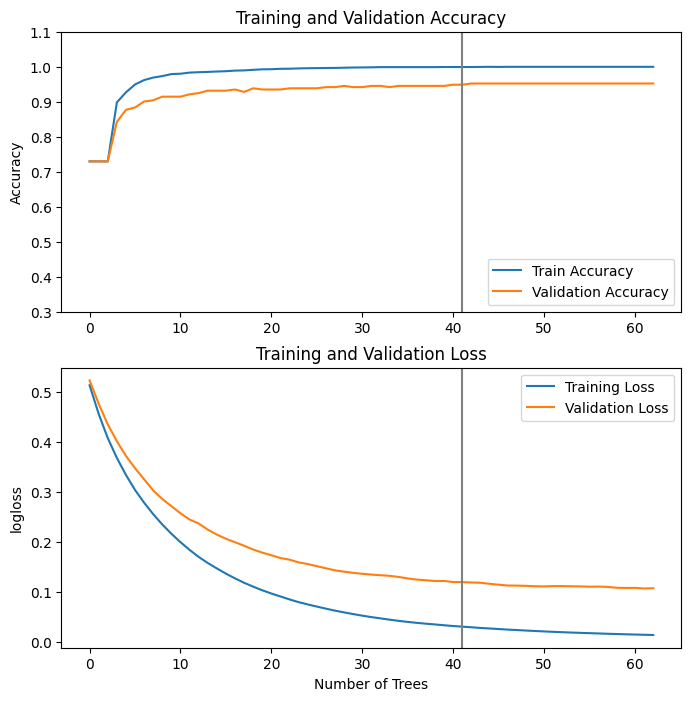

In [38]:
# Extract results
results = model.evals_result()
train_error = results['validation_0']['logloss']
val_error = results['validation_1']['logloss']
train_acc = [1.0 - i for i in results['validation_0']['error']]  # Use 'error'
val_acc = [1.0 - i for i in results['validation_1']['error']]    # Use 'error'


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1.1])
plt.axvline(model.best_iteration-1, color="gray", label="Optimal tree number")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_error, label='Training Loss')
plt.plot(val_error, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.axvline(model.best_iteration-1, color="gray", label="Optimal tree number")
plt.ylabel('logloss')
plt.xlabel('Number of Trees')
plt.show()


In [39]:
train_predictions = model.predict(train_features)
val_predictions = model.predict(val_features)
print ("Training Accuracy = ", accuracy_score(train_labels_encoded, train_predictions))
print ("Validation Accuracy = ", accuracy_score(val_labels_encoded, val_predictions))


Training Accuracy =  0.9991460290350128
Validation Accuracy =  0.952054794520548


Evaluating the Algorithm

Accuracy: 		 0.9556313993174061
Precision: 		 0.9554419185380344
Recall: 		 0.9556313993174061
F1 score: 		 0.9551358029385156 



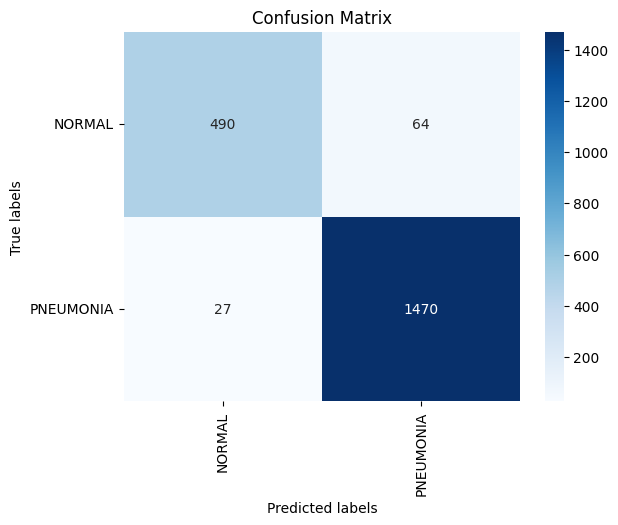

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_test = model.predict(test_features)

print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(test_labels_encoded, y_pred_test))
print('Precision: \t\t', precision_score(test_labels_encoded, y_pred_test, average='weighted'))
print('Recall: \t\t', recall_score(test_labels_encoded, y_pred_test, average='weighted'))
print('F1 score: \t\t', f1_score(test_labels_encoded, y_pred_test, average='weighted'), '\n')

CLASSES = le.classes_

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=test_labels_encoded, predictions=y_pred_test).numpy()
ax = plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
